In [41]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from transformers import BertModel, BertTokenizer

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sn

## Example sentences

In [30]:
words_of_interest = ['man', 'woman', 'king', 'queen']
sentences = ["A man is an adult male person",
             "A woman is an adult female person.",
             "A king is a male sovereign or monarch.",
             "A queen is a female sovereign or monarch."]

## Encode words

In [31]:
def encode_words(model_name_or_path, sentences, words_of_interest):
    """
    Given a list of sentences and a model, get the embeddings of each word in the sentences.
    """
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir ='../_cache') # Will output all hidden_states.

    print("   Tokenizing sentences...")
    marked_text = ["[CLS] " + sent + " [SEP]" for sent in sentences]
    tokenized_text = [tokenizer.tokenize(sent) for sent in marked_text]
    indexed_tokens = [tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_text]
    #indexed_tokens = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

    max_len = 0
    for i in indexed_tokens:
        if len(i) > max_len:
            max_len = len(i)
    print("   Maximum length in dataset: {}".format(max_len))

    print("   Padding/Truncating sentences according to the maximum length...")
    padded = np.array([i + [0]*(max_len-len(i)) for i in indexed_tokens])

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # Concatenate the tensors for all layers. We use `stack` here to create a new dimension in the tensor.
    hidden_states = torch.stack(output[2], dim=0)

    # Switch around the “layers” and “tokens” dimensions with permute.
    hidden_states = hidden_states.permute(1,2,0,3)
    
    # For each sentence, um the last four layers of each token as their embbeding.
    sentence_vecs = []
    for sent in hidden_states:
        token_vecs = []
        for token in sent:
            sum_vec = torch.sum(token[-4:], dim=0)
            token_vecs.append(np.array(sum_vec))
        sentence_vecs.append(token_vecs)
    sentence_vecs = np.array(sentence_vecs)
        
    # Create pandas dataframe.
    cols = ['feat'+str(i) for i in range(sentence_vecs.shape[2])]
    df = pd.DataFrame(columns=cols)
    df['Token'] = None
    df['Sentence'] = None
    
    for i, sent in enumerate(sentences):
        tmp_df = pd.DataFrame(data=sentence_vecs[i,:,:], columns=cols)
        tmp_df['Token'] = list(np.append(tokenized_text[i], ['[PAD]']*(max_len-len(tokenized_text[i]))))
        tmp_df['Sentence'] = [sent]*max_len
        df = pd.concat([df, tmp_df], axis=0)
        
    #df = df[df.Token == word_of_interest]
    df = df.loc[df['Token'].isin(words_of_interest)]
    df.reset_index(drop=True, inplace=True)
    return df


print("BERT-base")
bert_df = encode_words('bert-base-cased', sentences, words_of_interest)
print("NetBERT")
netbert_df = encode_words('../_models/netbert/checkpoint-1027000/', sentences, words_of_interest)

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Maximum length in dataset: 11
   Padding/Truncating sentences according to the maximum length...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Maximum length in dataset: 11
   Padding/Truncating sentences according to the maximum length...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


## Cosine similarity

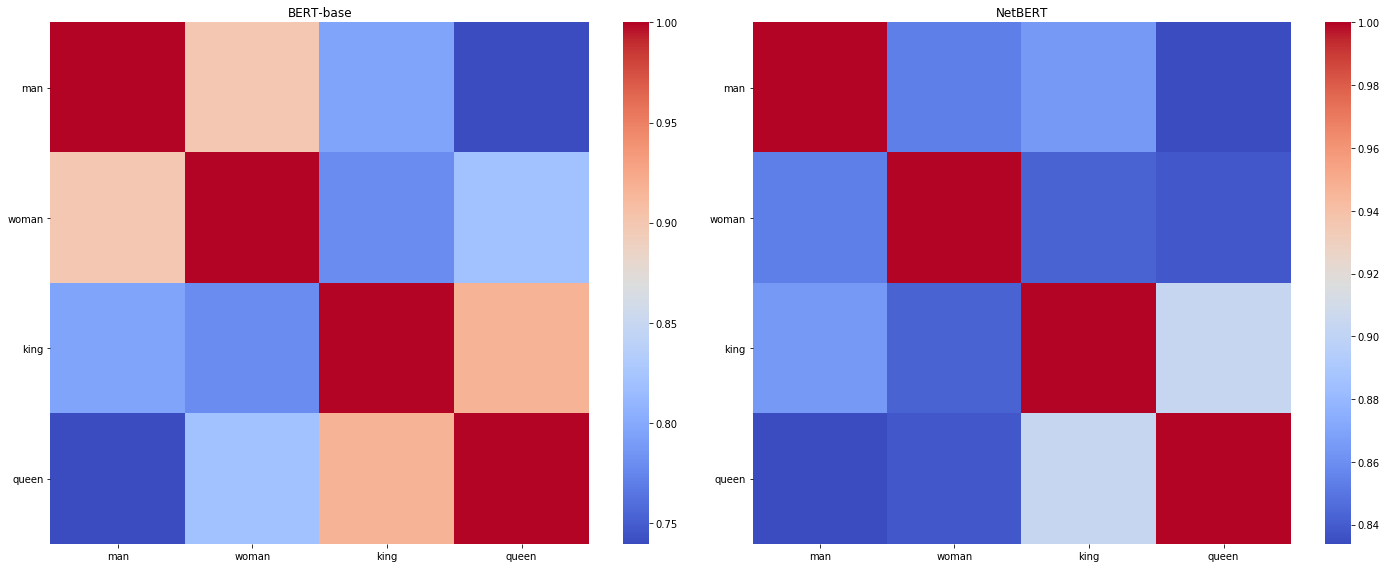

In [32]:
def compute_cosine_matrix(embeddings):
    """
    """
    matrix = np.zeros((len(sentences), len(sentences)))
    for i, sent in enumerate(sentences):
        for j, sent in enumerate(sentences):
            matrix[i,j] = 1 - cosine(embeddings[i], embeddings[j])
    return matrix


# Get embeddings.
bert_embeddings = bert_df.loc[:, ~bert_df.columns.isin(['Token','Sentence'])].values
netbert_embeddings = netbert_df.loc[:, ~netbert_df.columns.isin(['Token','Sentence'])].values

# Compute matrix.
bert_matrix = compute_cosine_matrix(bert_embeddings)
netbert_matrix = compute_cosine_matrix(netbert_embeddings)

# Create dataframes.
bert_cm = pd.DataFrame(bert_matrix, index=words_of_interest, columns=words_of_interest)
netbert_cm = pd.DataFrame(netbert_matrix, index=words_of_interest, columns=words_of_interest)

# Create heatmaps.
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1, 2, 1)
sn.heatmap(bert_cm, annot=False, cmap="coolwarm")
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=10, horizontalalignment='center', rotation=0) 
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10, rotation=0)
ax1.set_title("BERT-base")

ax2 = fig.add_subplot(1, 2, 2)
sn.heatmap(netbert_cm, annot=False, cmap="coolwarm")
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=10, horizontalalignment='center', rotation=0) 
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=10, rotation=0)
ax2.set_title("NetBERT")

plt.tight_layout()
plt.show()
#plt.savefig(outdir+"confusion_matrix.png")

## PCA

BERT-base - Explained variation per principal component: [0.6554163  0.26529393 0.07929009]
NetBERT - Explained variation per principal component: [0.44062078 0.34890306 0.21047616]


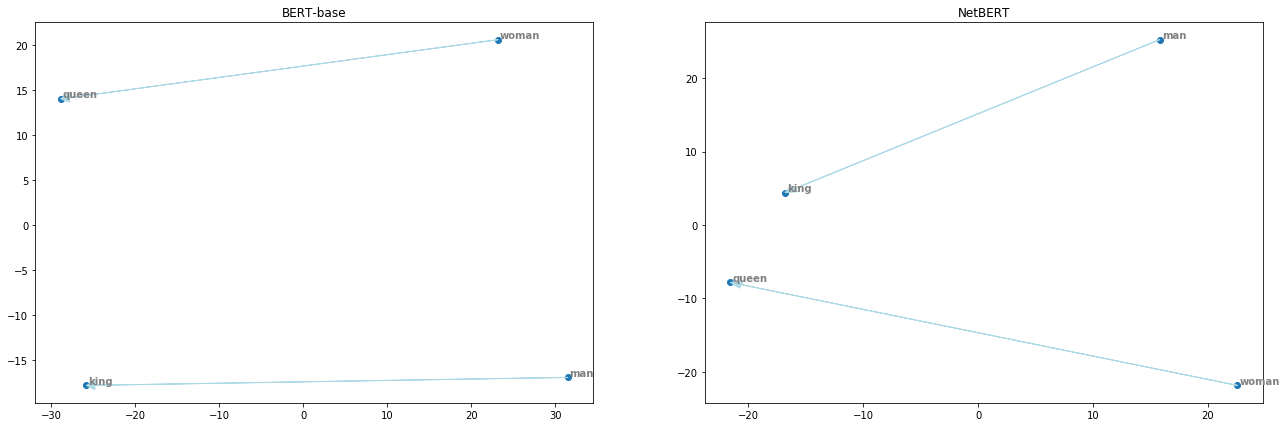

In [154]:
def perform_pca(df, word_embeddings, ax, title):
    """
    """
    pca = PCA(n_components=3, random_state = 42)
    pca_result = pca.fit_transform(word_embeddings)

    pca_df = df.copy(deep=True)
    pca_df['pca-one'] = pca_result[:,0]
    pca_df['pca-two'] = pca_result[:,1] 
    pca_df['pca-three'] = pca_result[:,2]
    print(title + ' - Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

    # Scatterplot.
    ax.scatter(x = pca_df['pca-one'].values, 
               y = pca_df['pca-two'].values)
    ax.set_title(title)
    for line in pca_df.index:
        ax.text(pca_df.loc[line,"pca-one"]+0.2, 
                 pca_df.loc[line,"pca-two"]+0.2, 
                 pca_df.loc[line,"Token"], 
                 horizontalalignment='left', 
                 size='medium', 
                 color='gray',
                 weight='semibold')
    
    # Vectors.
    man = pca_df.loc[pca_df.Token=='man', pca_df.columns.isin(['pca-one','pca-two'])].values[0].tolist()
    king = pca_df.loc[pca_df.Token=='king', pca_df.columns.isin(['pca-one','pca-two'])].values[0].tolist()
    woman = pca_df.loc[pca_df.Token=='woman', pca_df.columns.isin(['pca-one','pca-two'])].values[0].tolist()
    queen = pca_df.loc[pca_df.Token=='queen', pca_df.columns.isin(['pca-one','pca-two'])].values[0].tolist()
    ax.arrow(man[0], man[1], king[0]-man[0], king[1]-man[1], head_width=1, head_length=1, fc='lightblue', ec='lightblue', length_includes_head=True)
    ax.arrow(woman[0], woman[1], queen[0]-woman[0], queen[1]-woman[1], head_width=1, head_length=1, fc='lightblue', ec='lightblue', length_includes_head=True)
    return
    


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,7))
perform_pca(bert_df, bert_embeddings, ax1, 'BERT-base')
perform_pca(netbert_df, netbert_embeddings, ax2, 'NetBERT')
plt.show()

In [ ]:
# List Mark
DNS
mDNS

LAN
WAN
CAN
MAN

ACL
PACL
VACL

HSRP
VRRP
GLBP

EIGRP
IGRP
BGP
EBGP

STP
DTP
VTP